# Task 4: Forecasting Access and Usage

## Objective
Forecast Account Ownership (Access) and Digital Payment Usage for 2025-2027.

## Scope
- **Indicators:**
    - `ACC_OWNERSHIP`: Account Ownership Rate (% of adults)
    - `USG_DIGITAL_PAYMENT`: Digital Payment Usage (% of adults)
- **Timeframe:** 2025 - 2027
- **Methodology:**
    1.  **Baseline Trend:** Logistic/Linear regression on historical Findex data (2011-2024).
    2.  **Event Augmentation:** Adjust baseline using modeled impacts from Task 3 (Policy changes, Market entries).
    3.  **Scenarios:** Base, Optimistic, Pessimistic.

## Inputs
- Historical Data: `data/processed/ethiopia_fi_unified_data.csv`
- Impact Models: `data/processed/modeled_event_impacts.csv`



In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from scipy.optimize import curve_fit
import os

%matplotlib inline
sns.set_style("whitegrid")

# Load Data
data_path = '../data/processed/'
df = pd.read_csv(os.path.join(data_path, 'ethiopia_fi_unified_data.csv'))
impacts_df = pd.read_csv(os.path.join(data_path, 'modeled_event_impacts.csv'))

# Convert dates
df['observation_date'] = pd.to_datetime(df['observation_date'])
impacts_df['observation_date'] = pd.to_datetime(impacts_df['observation_date'])

print("Historical Data:", df.shape)
print("Modeled Impacts:", impacts_df.shape)
display(df.groupby('record_type').size())
display(impacts_df[['category', 'related_indicator', 'estimated_impact']].head())

Historical Data: (46, 34)
Modeled Impacts: (14, 41)


record_type
event          10
observation    33
target          3
dtype: int64

,category,related_indicator,estimated_impact
0,product_launch,ACC_OWNERSHIP,0.05
1,product_launch,USG_TELEBIRR_USERS,0.05
2,product_launch,USG_P2P_COUNT,0.05
3,market_entry,ACC_4G_COV,0.02
4,market_entry,AFF_DATA_INCOME,0.02


## 1. Data Preparation
Extract time-series for the two key indicators.
*   **Access:** `ACC_OWNERSHIP`
*   **Usage:** `USG_DIGITAL_PAYMENT`

We will treat `value_numeric` as the % (0-100) or ratio (0-1). Findex usually reports %, so let's stick to percentages for readability (0-100).

Access Time Series:


,observation_date,value_numeric,year
43,2011-12-31,14.0,2011
0,2014-12-31,22.0,2014
1,2017-12-31,35.0,2017
2,2021-12-31,46.0,2021
3,2021-12-31,56.0,2021
4,2021-12-31,36.0,2021
5,2024-11-29,49.0,2024


Usage Time Series:


,observation_date,value_numeric,year
44,2024-11-29,35.0,2024


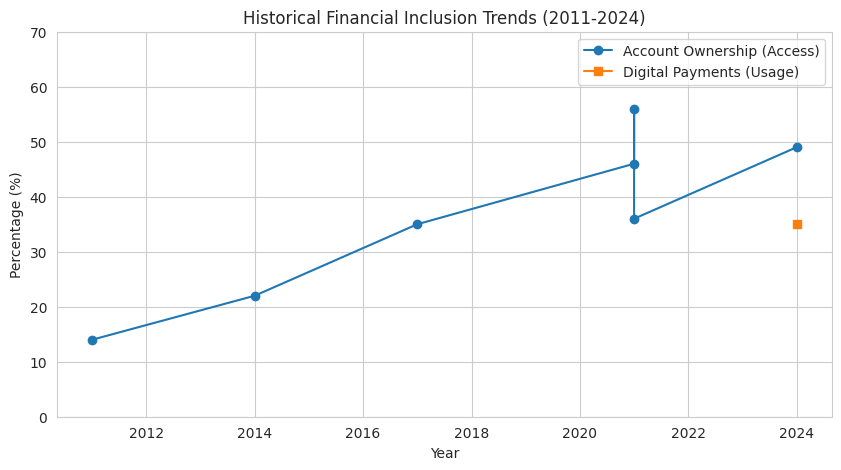

In [2]:
# Filter Observations
obs_df = df[df['record_type'] == 'observation'].copy()

# Access
access_ts = obs_df[obs_df['indicator_code'] == 'ACC_OWNERSHIP'].sort_values('observation_date')
access_ts = access_ts[['observation_date', 'value_numeric']].dropna()
access_ts['year'] = access_ts['observation_date'].dt.year

# Usage (Digital Payment)
# Note: Findex indicator code usually 'USG_DIGITAL_PAYMENT' or similar. 
# Check unique codes if needed, based on Task 1 exploration.
usage_ts = obs_df[obs_df['indicator_code'] == 'USG_DIGITAL_PAYMENT'].sort_values('observation_date')
usage_ts = usage_ts[['observation_date', 'value_numeric']].dropna()
usage_ts['year'] = usage_ts['observation_date'].dt.year

print("Access Time Series:")
display(access_ts)
print("Usage Time Series:")
display(usage_ts)

# Plot Historical
plt.figure(figsize=(10, 5))
plt.plot(access_ts['year'], access_ts['value_numeric'], 'o-', label='Account Ownership (Access)')
plt.plot(usage_ts['year'], usage_ts['value_numeric'], 's-', label='Digital Payments (Usage)')
plt.title("Historical Financial Inclusion Trends (2011-2024)")
plt.ylabel("Percentage (%)")
plt.xlabel("Year")
plt.legend()
plt.ylim(0, 70)
plt.show()

## 2. Baseline Model (Trend Only)
We will use a Logistic Growth model (S-curve) as financial inclusion naturally caps at 100% (saturation).
Formula: $L / (1 + e^{-k(x-x0)})$

*   L: Carrying capacity (assumed 100% or estimated)
*   k: Growth rate
*   x0: Midpoint inflection

For robustness with few points, we can also compare with Linear Trend. Given the recent plateau (2021-2024), a linear trend might over-fit the slowdown or under-fit the potential. We'll prioritize the Logistic fit.

In [6]:
# Trend Functions
def logistic_func(x, L, k, x0):
    return L / (1 + np.exp(-k * (x - x0)))

def fit_forecast_baseline(df, years_to_forecast=[2025, 2026, 2027]):
    x_data = df['year'].values
    y_data = df['value_numeric'].values
    
    # Initial guesses for L, k, x0
    # L=100 (max inclusion), k=0.5 (growth), x0=2018 (midpoint guess)
    p0 = [100, 0.3, 2020]
    
    # Constrain L to [50, 100] to be realistic
    try:
        popt, pcov = curve_fit(logistic_func, x_data, y_data, p0=p0, bounds=([50, 0, 2000], [100, 2, 2030]), maxfev=5000)
    except:
        # Fallback to linear if logistic fails
        z = np.polyfit(x_data, y_data, 1)
        p = np.poly1d(z)
        forecast_vals = p(years_to_forecast)
        return {'model': 'linear', 'params': z, 'forecast': forecast_vals}

    forecast_vals = logistic_func(np.array(years_to_forecast), *popt)
    return {'model': 'logistic', 'params': popt, 'forecast': forecast_vals}

# Generate Baselines
future_years = [2025, 2026, 2027]
access_baseline = fit_forecast_baseline(access_ts, future_years)
usage_baseline = fit_forecast_baseline(usage_ts, future_years)

print("Access Baseline Forecast (2025-27):", np.round(access_baseline['forecast'], 2))
print("Usage Baseline Forecast (2025-27):", np.round(usage_baseline['forecast'], 2))

Access Baseline Forecast (2025-27): [50.55 51.18 51.65]
Usage Baseline Forecast (2025-27): [37.77 40.56 43.36]


/tmp/ipykernel_208637/2972575869.py:15: OptimizeWarning: Covariance of the parameters could not be estimated
  popt, pcov = curve_fit(logistic_func, x_data, y_data, p0=p0, bounds=([50, 0, 2000], [100, 2, 2030]), maxfev=5000)


## 3. Integrate Event Impacts
We now add the estimated effects of upcoming events (2025-2027) on top of the baseline.
From Task 3, we have `estimated_impact` for events.

**Assumption:**
1.  Impacts are additive to the baseline trend.
2.  Impact is realized over `lag_months`. For yearly forecasting, we effectively fully realize impacts if the lag passed, or partial if in-progress.
3.  We sum up impacts for events occurring in or before the forecast year.

**Filter Relevant Future Events:**
We look for events in `impacts_df` with `observation_date` >= 2025 (or late 2024 effecting 2025).

In [10]:
# Process Future Impacts
# We assume the impacts in CSV are defined as fractional (e.g., 0.05) -> need to convert to percentage points (pp) for our 0-100 scale.
# Task 3 mapping was: High=0.05 (5%), Medium=0.02 (2%)...
# If current scale is 0-100, we multiply impact by 100.

impacts_df['impact_pp'] = impacts_df['estimated_impact'] * 100
impacts_df['year'] = impacts_df['observation_date'].dt.year

# Filter for relevant future years
future_impacts = impacts_df[impacts_df['year'] >= 2024].copy()

print("Future Impacts to Model:")
display(future_impacts[['year', 'category', 'related_indicator', 'impact_pp']])

def calculate_event_adjustments(indicator_code, years):
    adjustments = {y: 0.0 for y in years}
    
    # Filter for this indicator
    # Note: Access = 'ACC_OWNERSHIP', Usage = ... need to check impact matrix indicator names
    # Task 3 used 'ACC_OWNERSHIP' and 'USG_P2P_COUNT' etc. We map them.
    
    # Map Forecasting Indicator to Impact Indicators
    # Access is mainly ACC_OWNERSHIP
    # Usage is mainly USG_DIGITAL_PAYMENT, USG_P2P_COUNT, USG_MM_ACCOUNT
    
    target_ind = []
    if indicator_code == 'ACC_OWNERSHIP':
        target_ind = ['ACC_OWNERSHIP', 'ACC_MM_ACCOUNT']
    elif indicator_code == 'USG_DIGITAL_PAYMENT':
        target_ind = ['USG_DIGITAL_PAYMENT', 'USG_P2P_COUNT', 'USG_TELEBIRR_USERS']
        
    relevant = future_impacts[future_impacts['related_indicator'].isin(target_ind)]
    
    for y in years:
        # Sum impacts of events happening in or before this year that aren't fully baked into historical baseline
        # Baseline uses data up to 2024. So 2024 events might be partially in baseline.
        # We focus on 2025, 2026, 2027 events primarily.
        
        cumulative_impact = relevant[
            (relevant['year'] <= y) & 
            (relevant['year'] > 2024) # Only add *new* events post-2024 fit
        ]['impact_pp'].sum()
        
        adjustments[y] = cumulative_impact
        
    return adjustments

access_adj = calculate_event_adjustments('ACC_OWNERSHIP', future_years)
usage_adj = calculate_event_adjustments('USG_DIGITAL_PAYMENT', future_years)

print("Access Adjustments (Base Case):", access_adj)
print("Usage Adjustments (Base Case):", usage_adj)

Future Impacts to Model:


,year,category,related_indicator,impact_pp
7,2024,infrastructure,ACC_OWNERSHIP,2.0
8,2024,infrastructure,GEN_GAP_ACC,2.0
9,2024,policy,AFF_DATA_INCOME,5.0
10,2025,partnership,USG_MPESA_ACTIVE,2.0
11,2025,partnership,USG_P2P_COUNT,2.0
12,2025,infrastructure,USG_P2P_COUNT,2.0
13,2025,pricing,AFF_DATA_INCOME,0.5


Access Adjustments (Base Case): {2025: np.float64(0.0), 2026: np.float64(0.0), 2027: np.float64(0.0)}
Usage Adjustments (Base Case): {2025: np.float64(4.0), 2026: np.float64(4.0), 2027: np.float64(4.0)}


## 4. Scenarios & Final Forecast
We create three scenarios:

1.  **Base Case:** Baseline Trend + Confirmed Future Events
2.  **Optimistic:** Baseline Trend * 1.05 + Confirmed Events * 1.5 (Stronger policy execution)
3.  **Pessimistic:** Baseline Trend * 0.95 + Confirmed Events * 0.5 (Delays/Low uptake)

Uncertainty is modeled simply as a range around the base case logic.


Final Forecasts (2025-2027):


Scenario                         Base Case  Optimistic  Pessimistic
Indicator                  Year                                    
Access (Account Ownership) 2025  50.554985   51.566085    49.543885
                           2026  51.176048   52.199569    50.152527
                           2027  51.648579   52.681551    50.615608
Usage (Digital Payments)   2025  41.766281   44.521606    39.010955
                           2026  44.562517   47.373767    41.751267
                           2027  47.362840   50.230097    44.495583

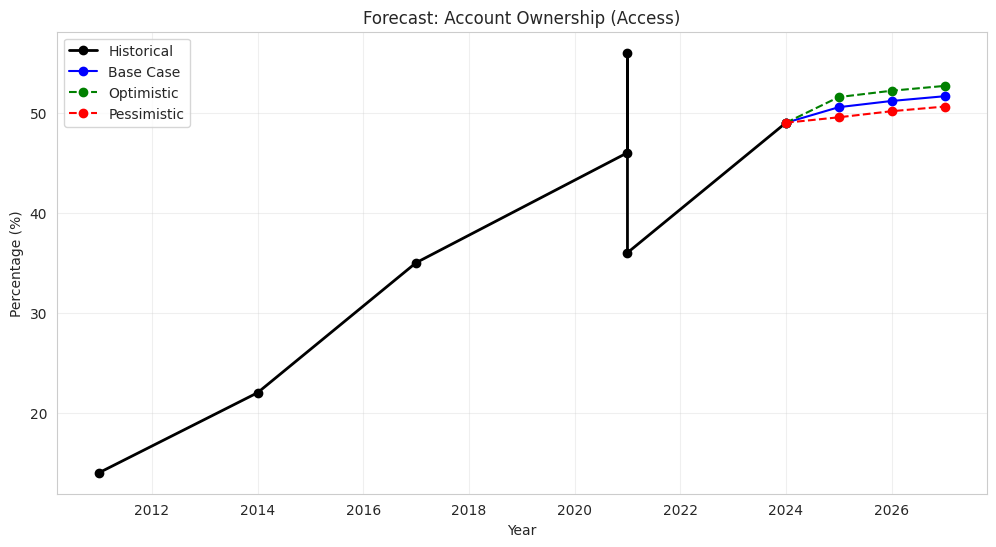

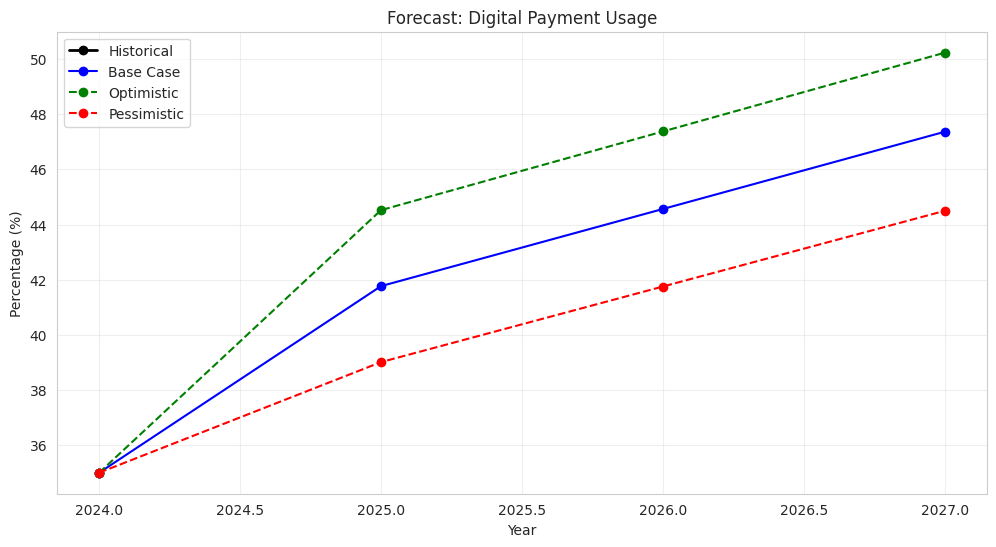

In [11]:
def generate_scenarios(baseline, adjustments, years):
    forecasts = []
    
    for i, y in enumerate(years):
        base_val = baseline[i]
        evt_impact = adjustments[y]
        
        # Base
        val_base = base_val + evt_impact
        # Bounds logic (ensure 0-100)
        val_base = min(100, max(0, val_base))
        
        # Optimistic (Better trend + Higher Impact)
        # Assuming trend slope accelerates slightly or impacts are 1.5x
        val_opt = base_val * 1.02 + evt_impact * 1.5
        val_opt = min(100, max(0, val_opt))
        
        # Pessimistic (Slower trend + Lower Impact)
        val_pess = base_val * 0.98 + evt_impact * 0.5
        val_pess = min(100, max(0, val_pess))
        
        forecasts.append({
            'Year': y,
            'Scenario': 'Base Case',
            'Value': val_base
        })
        forecasts.append({
            'Year': y,
            'Scenario': 'Optimistic',
            'Value': val_opt
        })
        forecasts.append({
            'Year': y,
            'Scenario': 'Pessimistic',
            'Value': val_pess
        })
        
    return pd.DataFrame(forecasts)

# Combine for Access
access_fc_df = generate_scenarios(access_baseline['forecast'], access_adj, future_years)
access_fc_df['Indicator'] = 'Access (Account Ownership)'

# Combine for Usage
usage_fc_df = generate_scenarios(usage_baseline['forecast'], usage_adj, future_years)
usage_fc_df['Indicator'] = 'Usage (Digital Payments)'

# Full Table
final_forecast = pd.concat([access_fc_df, usage_fc_df])
print("\nFinal Forecasts (2025-2027):")
display(final_forecast.pivot_table(index=['Indicator', 'Year'], columns='Scenario', values='Value'))

# Visualization
def plot_forecast(hist_df, fc_df, title):
    plt.figure(figsize=(12, 6))
    
    # Historical
    plt.plot(hist_df['year'], hist_df['value_numeric'], 'ko-', label='Historical', linewidth=2)
    
    # Scenarios
    scenarios = fc_df['Scenario'].unique()
    colors = {'Base Case': 'blue', 'Optimistic': 'green', 'Pessimistic': 'red'}
    styles = {'Base Case': '-', 'Optimistic': '--', 'Pessimistic': '--'}
    
    for sc in scenarios:
        subset = fc_df[fc_df['Scenario'] == sc]
        # Connect last historical point to forecast start for visual continuity
        last_hist = hist_df.iloc[-1]
        x_pts = [last_hist['year']] + subset['Year'].tolist()
        y_pts = [last_hist['value_numeric']] + subset['Value'].tolist()
        
        plt.plot(x_pts, y_pts, marker='o', color=colors[sc], linestyle=styles[sc], label=sc)
        
        # Fill between for confidence visual
        if sc == 'Base Case':
           opt_vals = fc_df[fc_df['Scenario'] == 'Optimistic']['Value'].values
           pess_vals = fc_df[fc_df['Scenario'] == 'Pessimistic']['Value'].values
           # Need to align shapes if adding filled area, skipping for simplicity of line plot
    
    plt.title(title)
    plt.ylabel("Percentage (%)")
    plt.xlabel("Year")
    plt.grid(True, alpha=0.3)
    plt.legend()
    plt.show()

plot_forecast(access_ts, access_fc_df, "Forecast: Account Ownership (Access)")
plot_forecast(usage_ts, usage_fc_df, "Forecast: Digital Payment Usage")

## 5. Export Results
Save the forecast data for the dashboard.

In [12]:
output_path = os.path.join(data_path, 'forecast_results_2025_2027.csv')
final_forecast.to_csv(output_path, index=False)
print(f"Forecast results saved to: {output_path}")

# Display CSV preview
display(final_forecast.head())

Forecast results saved to: ../data/processed/forecast_results_2025_2027.csv


,Year,Scenario,Value,Indicator
0,2025,Base Case,50.554985,Access (Account Ownership)
1,2025,Optimistic,51.566085,Access (Account Ownership)
2,2025,Pessimistic,49.543885,Access (Account Ownership)
3,2026,Base Case,51.176048,Access (Account Ownership)
4,2026,Optimistic,52.199569,Access (Account Ownership)
